# EDS-TEM quantification of core shell nanoparticles

Using machine learning methods, such as independent component analysis (ICA), the composition of embedded nanostructures, such as core-shell nanoparticles, can be accurately measured as demonstrated by D. Roussow et al., Nano Letters, 2015 (see the [full article](https://www.repository.cam.ac.uk/bitstream/handle/1810/248102/Roussouw%20et%20al%202015%20Nano%20Letters.pdf?sequence=1)). Using the same data, this notebook reproduces the main results of this article.


## Author

* 13/04/2015 Pierre Burdet - Developed for HyperSpy workshop at University of Cambridge

## Changes

* 29/05/2016 Duncan Johnstone. Update the syntax for HyperSpy 0.8.5 (Python 3 compatibility)
* 03/08/2016 Francisco de la Peña. Update the syntax for HyperSpy 1.1
* 06/08/2016 Francisco de la Peña. Update the syntax for HyperSpy 0.8.1
* 27/08/2016 Pierre Burdet. Update for workshop at EMC Lyon

## Requirements

* HyperSpy 1.1
* Mayavi (for some parts)

## <a id='top'></a> Contents

1. <a href='dat'> Specimen & Data</a>
2. <a href='#loa'> Loading</a>
3. <a href='#bss'> Blind source separation of core/shell nanoparticles</a>
4. <a href='#bare'> Representative spectrum from bare cores</a>
5. <a href='#com'> Comparison and quantification</a>
6. <a href='#fur'> Going father: Isolating the nanoparticles</a>

# <a id='dat'></a> 1. Specimen & Data

The sample and the data used in this tutorial are described in 
D. Roussow, et al., Nano Letters, In Press (2015) (see the [full article](https://www.repository.cam.ac.uk/bitstream/handle/1810/248102/Roussouw%20et%20al%202015%20Nano%20Letters.pdf?sequence=1)).

FePt@Fe$_3$O$_4$ core-shell nanoparticles are investigated with an EDS/TEM experiment (FEI Osiris TEM, 4 EDS detectors). The composition of the core can be measured with ICA (see figure 1c). To prove the accuracy of the results, measurements on bare FePt bimetallic nanoparticles from a synthesis prior to the shell addition step are used.

<img src="images/core_shell.png" style="height:350px;">
Figure 1: (a) A spectrum image obtained from a cluster of core-shell nanoparticles. (b) The nanoparticles are comprised of a bi-metallic Pt/Fe core surrounded by an iron oxide shell on a carbon support. (c) ICA decomposes the mixed EDX signals into components representing the core (IC#0), shell (IC#1) and support (IC#2).

In [1]:
#Download the data (1MB)
from urllib.request import urlretrieve, urlopen
fnames= ['bare_core.hdf5', 'core_shell.hdf5']   
url = 'http://cook.msm.cam.ac.uk//~hyperspy//EDS_tutorial//'
files = [urlretrieve(url + fname, fname) for fname in fnames]

# <a id='loa'></a> 2. Loading

<a href='#top'> Table of contents</a>

Import HyperSpy, numpy and matplotlib libraries

In [1]:
%matplotlib qt4
import hyperspy.api as hs

For a nice on-line display (optional)

In [2]:
%matplotlib inline

Load the spectrum images of the bare seeds and the core shell nanoparticles.

In [3]:
c = hs.load('bare_core.hdf5')
cs = hs.load('core_shell.hdf5')

In [4]:
c.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── EDS
│       │       ├── azimuth_angle = 0.0
│       │       ├── elevation_angle = 35.0
│       │       └── energy_resolution_MnKa = 133.31
│       ├── acquisition_mode = STEM
│       ├── beam_energy = 200.0
│       ├── microscope = Microscope TecnaiOsiris 200 kV D658 AnalyticalTwin
│       └── tilt_stage = 0.0
├── General
│   ├── date = 14.10.2014
│   └── title = Bare core
├── Sample
│   ├── elements = array(['Fe', 'Pt'], 
      dtype='<U2')
│   └── xray_lines = array(['Fe_Ka', 'Pt_La'], 
      dtype='<U5')
└── Signal
    ├── binned = True
    ├── signal_origin = 
    └── signal_type = EDS_TEM

Plot the intensity of Fe K${\alpha}$ and Pt L${\alpha}$.

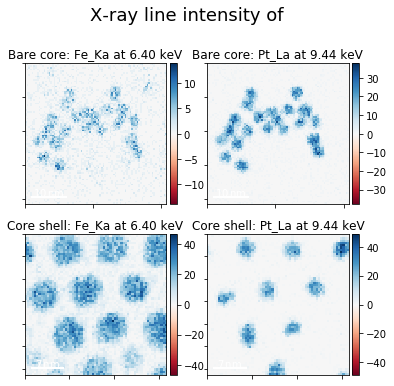

In [7]:
axes = hs.plot.plot_images(hs.transpose(*(c.get_lines_intensity() + cs.get_lines_intensity())),
                           scalebar='all', axes_decor=None, per_row=2, cmap='RdBu')

## <a id='bss'></a> 3. Blind source separation of core/shell nanoparticles

<a href='#top'> Table of contents</a>

Apply blind source separation (ICA) to obtain a factor (spectrum) corresponding to the core.

In [8]:
cs.change_dtype('float')
cs.decomposition()

INFO:hyperspy.learn.mva:Scaling the data to normalize the (presumably) Poissonian noise
INFO:hyperspy.learn.mva:Performing decomposition analysis
INFO:hyperspy.learn.mva:Undoing data pre-treatments


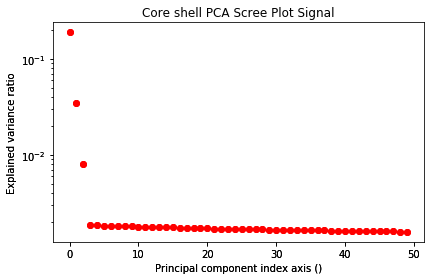

In [9]:
ax = cs.plot_explained_variance_ratio()

ICA on the three first components.

In [10]:
cs.blind_source_separation(3)

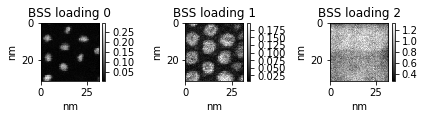

In [11]:
axes = cs.plot_bss_loadings()

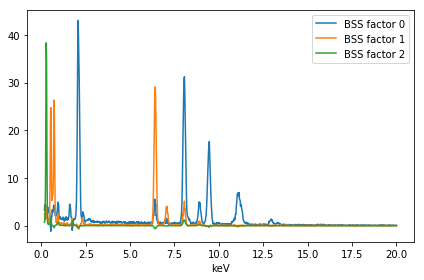

In [12]:
axes = cs.plot_bss_factors()

The first component corresponds to the core.

In [13]:
s_bss = cs.get_bss_factors().inav[0]

## <a id='bare'></a> 4. Representative spectrum from bare cores

<a href='#top'> Table of contents</a>

To obtain a representative spectrum of the bare nanoparticles, the low intensity of Pt L${\alpha}$ is masked.

In [14]:
pt_la = c.get_lines_intensity(['Pt_La'])[0]
mask = pt_la > 6

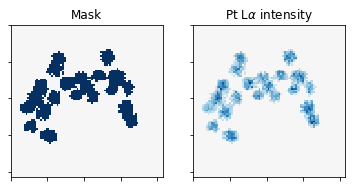

In [17]:
axes = hs.plot.plot_images(hs.transpose(*(mask, pt_la * mask)), axes_decor=None, colorbar=None,
                           label=['Mask', 'Pt L${\\alpha}$ intensity'], cmap='RdBu')

To apply the mask, the navigation dimensions of the mask must be manipulated to match the navigation dimensions of the EDS spectrum image. This is achieved crudely via first generating a mask using the built in vacuum_mask() method and then overwriting the data with the mask generated above.

In [18]:
c_mask = c.sum(-1)
c_mask.data = mask.data

The sum over the particles is used as a bare core spectrum.

In [19]:
s_bare = (c * c_mask).sum()

## <a id='com'></a> 5. Comparison and quantification

<a href='#top'> Table of contents</a>

Stack together the spectrum of bare particles and the first ICA component.

In [20]:
s_bare.change_dtype('float')
s = hs.stack([s_bare, s_bss], new_axis_name='Bare or BSS')
s.metadata.General.title = 'Bare or BSS'

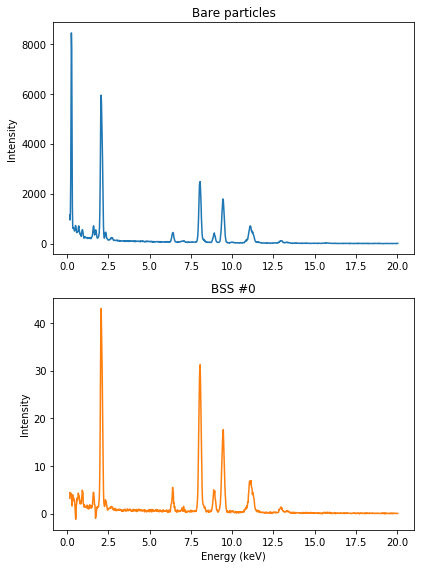

In [21]:
axes = hs.plot.plot_spectra(s, style='mosaic', legend=['Bare particles', 'BSS #0'])

### Method 1

X-ray intensities measurement with background subtraction.

In [22]:
w = s.estimate_background_windows()

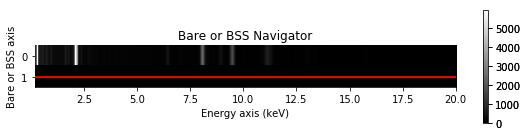

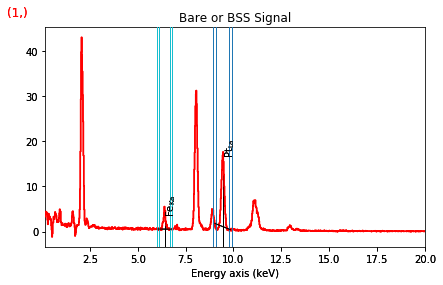

In [23]:
s.plot(background_windows=w)

Refinement of the windows position.

In [24]:
w

array([[ 5.99000266,  6.12796844,  6.67983156,  6.81779734],
       [ 8.95253846,  9.11572564,  9.76847436,  9.93166154]])

In [25]:
w[1, 0] = 8.44
w[1, 1] = 8.65

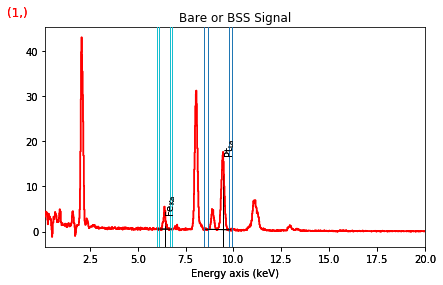

In [26]:
s.plot(background_windows=w, navigator='slider')

In [27]:
sI = s.get_lines_intensity(background_windows=w)

### Method 2

Measure X-ray intensity by fitting a Gaussian model

In [28]:
m = s.isig[5.:15.].create_model()

In [29]:
m.add_family_lines(['Cu_Ka', 'Co_Ka'])

In [30]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |  background_order_6 |  background_order_6 |          Polynomial
   1 |               Fe_Ka |               Fe_Ka |            Gaussian
   2 |               Fe_Kb |               Fe_Kb |            Gaussian
   3 |               Pt_La |               Pt_La |            Gaussian
   4 |              Pt_Lg3 |              Pt_Lg3 |            Gaussian
   5 |               Pt_Ln |               Pt_Ln |            Gaussian
   6 |              Pt_Lb2 |              Pt_Lb2 |            Gaussian
   7 |              Pt_Lg1 |              Pt_Lg1 |            Gaussian
   8 |               Pt_Ll |               Pt_Ll |            Gaussian
   9 |              Pt_Lb4 |              Pt_Lb4 |            Gaussian
  10 |              Pt_Lb1 |              Pt_Lb1 |            Gaussian
  11 |              Pt_Lb3 |              Pt_Lb3 |            Gaussian
  12 |

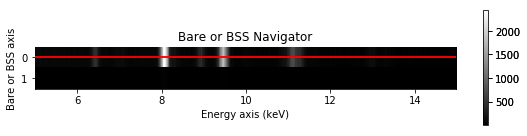

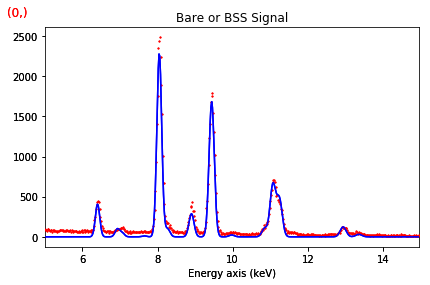

In [31]:
m.plot()

In [32]:
m.multifit()

In [33]:
m.fit_background()

In [34]:
m.calibrate_energy_axis()

/home/fjd29/Anaconda/anaconda3/lib/python3.5/site-packages/hyperspy/models/edsmodel.py:447: UserWarning: Energy resolution (FWHM at Mn Ka) changed from 133.310000 to 141.830070 eV
  "%lf to %lf eV" % (FWHM_MnKa_old, FWHM_MnKa))


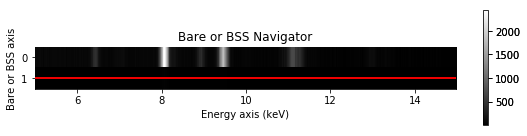

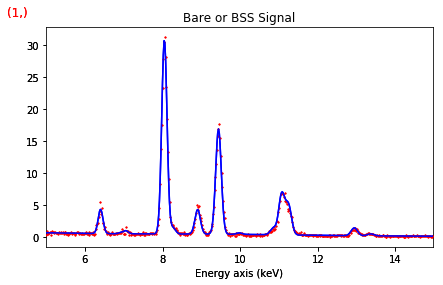

In [35]:
m.plot()

In [36]:
sI = m.get_lines_intensity()[-2:]

Set up the kfactors for Fe K${\alpha}$ and Pt L${\alpha}$.

In [37]:
#From Brucker software (Esprit)
kfactors = [1.450226, 5.075602]

Quantify with Cliff Lorimer.

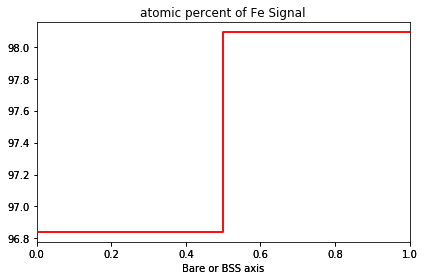

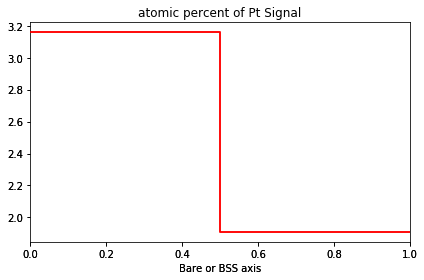

In [38]:
composition = s.quantification(method="CL", intensities=sI, factors=kfactors,
                 plot_result=True)

## <a id='fur'></a> 6. Going further

<a href='#top'> Table of contents</a>

Further image processing with [scikit-image](http://scikit-image.org/) and [scipy](http://www.scipy.org/). Apply a watershed transformation to isolate the nanoparticles.

- Transform the mask into a distance map.
- Find local maxima.
- Apply the watershed to the distance map using the local maximum as seed (markers).

Adapted from this scikit-image [example](http://scikit-image.org/docs/dev/auto_examples/plot_watershed.html).

In [39]:
from scipy.ndimage import distance_transform_edt, label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

In [40]:
distance = distance_transform_edt(mask.data)
local_maxi = peak_local_max(distance, indices=False,
                            min_distance=2, labels=mask.data)
labels = watershed(-distance, markers=label(local_maxi)[0],
                   mask=mask.data)

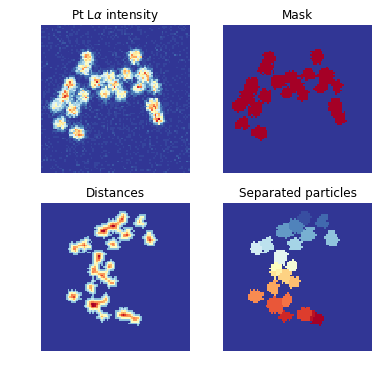

In [45]:
axes = hs.plot.plot_images(
    [pt_la.T, mask.T, hs.signals.Signal2D(distance), hs.signals.Signal2D(labels)],
    axes_decor='off', per_row=2, colorbar=None, cmap='RdYlBu_r',
    label=['Pt L${\\alpha}$ intensity', 'Mask',
           'Distances', 'Separated particles'])